In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
#print(df.describe())
df = pd.read_csv('02-21-2018.csv')
feature_names = df.columns
feature_list = list(feature_names)
print(feature_list)

['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd By

Method 1: Basic algorithm, manually select some features, calculate thresholds, and perform detection judgment.

In [3]:
%%time
df = pd.read_csv('02-21-2018.csv')
df_ddos_true = df[df['Label'].str.contains("DDOS", case=False)]

# Specified features
features = ['Flow Pkts/s', 'Flow Byts/s', 'Fwd Pkt Len Max', 'SYN Flag Cnt', 'Tot Fwd Pkts', 'Init Fwd Win Byts', 'Fwd IAT Tot', 'Pkt Size Avg', 'Flow Duration', 'Fwd Pkts/s', 'PSH Flag Cnt', 'Fwd PSH Flags', 'Fwd Pkt Len Max']

# Calculate thresholds dynamically and save them to a dictionary
thresholds = {feature: df[feature].quantile(0.7) for feature in features}

# Print calculated percentile thresholds to ensure correctness
# for feature, threshold in thresholds.items():
#     print(f"{feature}'s the 80th-percentile: {threshold}")

# Mark potential DDoS attacks
df['is_ddos_pred'] = df.apply(lambda row: sum(row[feature] > thresholds[feature] for feature in thresholds) >= 1, axis=1)

CPU times: user 54.1 s, sys: 2.1 s, total: 56.2 s
Wall time: 56.2 s


In [4]:
# Extracting index sets
true_ddos_indices = set(df_ddos_true.index)
predicted_ddos_indices = set(df[df['is_ddos_pred'] == True].index)
all_indices = set(df.index)

# Calculating metrics
true_positives = len(true_ddos_indices & predicted_ddos_indices)
false_positives = len(predicted_ddos_indices - true_ddos_indices)
false_negatives = len(true_ddos_indices - predicted_ddos_indices)
true_negatives = len(all_indices - true_ddos_indices - predicted_ddos_indices)

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
accuracy = (true_positives + true_negatives) / len(all_indices) if len(all_indices) > 0 else 0
specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Percentage of true positives among traffic labeled as DDoS (i.e., recall)
recall_percentage = recall * 100
# Printing results
print(f"True Positives (Correctly identified DDoS): {true_positives}")
print(f"False Positives (Incorrectly labeled as DDoS): {false_positives}")
print(f"False Negatives (Missed DDoS): {false_negatives}")
# Printing statistical metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f} ({recall_percentage:.2f}%)")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Specificity: {specificity:.4f}")

# Summary
print(f"\nSummary: Our algorithm identified {recall_percentage:.2f}% of the traffic labeled as DDoS in the original dataset.")

True Positives (Correctly identified DDoS): 372039
False Positives (Incorrectly labeled as DDoS): 353705
False Negatives (Missed DDoS): 315703
Precision: 0.5126
Recall: 0.5410 (54.10%)
F1 Score: 0.5264
Accuracy: 0.3616
Specificity: 0.0198

Summary: Our algorithm identified 54.10% of the traffic labeled as DDoS in the original dataset.


Method 2: Setting Recognition Conditions Based on Characteristics of Different DDOS Attack Types

In [5]:
%%time
df = pd.read_csv('02-21-2018.csv')

# Assume the data with filtered true DDoS labels is available
df_ddos_true = df[df['Label'].str.contains("DDOS", case=False)]

# Specified features and dynamic threshold setting based on attack types
features = ['Flow Pkts/s', 'Flow Byts/s', 'Fwd Pkt Len Max', 'SYN Flag Cnt', 
            'Tot Fwd Pkts', 'Init Fwd Win Byts', 'Fwd IAT Tot', 'Pkt Size Avg', 
            'Flow Duration', 'Fwd Pkts/s', 'PSH Flag Cnt', 'Fwd PSH Flags', 
            'Fwd Pkt Len Max']

# Calculate the 95th percentile as thresholds dynamically
thresholds = {feature: df[feature].quantile(0.7) for feature in features}

# Adjust thresholds based on different attack characteristics
# Note: These thresholds need to be adjusted based on specific data and attack behaviors
# For example, LOIC-UDP may result in particularly high Flow Pkts/s, while HOIC may lead to high SYN Flag Cnt
# Here's an example method of adjusting thresholds based on existing features
attack_type_adjustments = {
    'Flow Pkts/s': 1.2,  # Assume LOIC-UDP would result in higher packet rates
    'SYN Flag Cnt': 1.5,  # Assume HOIC attacks would have more SYN flags
}

# Applying adjustments
for feature, adjustment in attack_type_adjustments.items():
    if feature in thresholds:
        thresholds[feature] *= adjustment

# Mark potential DDoS attacks
df['is_ddos_pred'] = df.apply(lambda row: sum(row[feature] > thresholds[feature] for feature in features) >= 2, axis=1)

CPU times: user 56.5 s, sys: 1.74 s, total: 58.3 s
Wall time: 58.3 s


In [6]:
# Extracting index sets
true_ddos_indices = set(df_ddos_true.index)
predicted_ddos_indices = set(df[df['is_ddos_pred'] == True].index)
all_indices = set(df.index)

# Calculating metrics
true_positives = len(true_ddos_indices & predicted_ddos_indices)
false_positives = len(predicted_ddos_indices - true_ddos_indices)
false_negatives = len(true_ddos_indices - predicted_ddos_indices)
true_negatives = len(all_indices - true_ddos_indices - predicted_ddos_indices)

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
accuracy = (true_positives + true_negatives) / len(all_indices) if len(all_indices) > 0 else 0
specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Percentage of true positives among traffic labeled as DDoS (i.e., recall)
recall_percentage = recall * 100
# Printing results
print(f"True Positives (Correctly identified DDoS): {true_positives}")
print(f"False Positives (Incorrectly labeled as DDoS): {false_positives}")
print(f"False Negatives (Missed DDoS): {false_negatives}")
# Printing statistical metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f} ({recall_percentage:.2f}%)")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Specificity: {specificity:.4f}")

# Summary
print(f"\nSummary: Our algorithm identified {recall_percentage:.2f}% of the traffic labeled as DDoS in the original dataset.")

True Positives (Correctly identified DDoS): 302071
False Positives (Incorrectly labeled as DDoS): 336127
False Negatives (Missed DDoS): 385671
Precision: 0.4733
Recall: 0.4392 (43.92%)
F1 Score: 0.4556
Accuracy: 0.3116
Specificity: 0.0685

Summary: Our algorithm identified 43.92% of the traffic labeled as DDoS in the original dataset.


In [7]:
# Get all unique values of the 'Label' column
unique_labels = df['Label'].unique()

# Calculate the number of unique values
number_of_unique_labels = len(unique_labels)

# Print the result
print(f"There are {number_of_unique_labels} different values in the 'Label' column.")

# If you also want to see what these specific values are
print("These values include:", unique_labels)

There are 3 different values in the 'Label' column.
These values include: ['Benign' 'DDOS attack-LOIC-UDP' 'DDOS attack-HOIC']


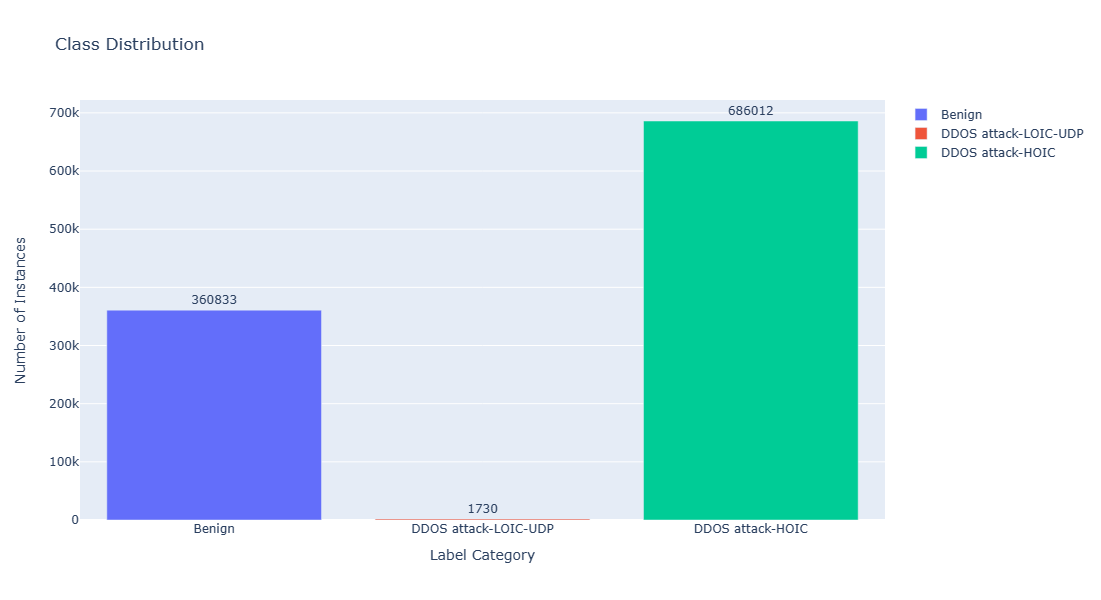

In [8]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
import plotly.graph_objs as go

init_notebook_mode(connected=True)

df = pd.read_csv('02-21-2018.csv')
label_counts = df["Label"].value_counts()

fig = go.Figure(data=[
    go.Bar(name='Benign', 
           y=[label_counts['Benign']],
           x=['Benign'],
           text=[label_counts['Benign']],
           orientation='v',
           textposition='outside',),
    go.Bar(name='DDOS attack-LOIC-UDP', 
           y=[label_counts['DDOS attack-LOIC-UDP']],
           x=['DDOS attack-LOIC-UDP'],
           text=[label_counts['DDOS attack-LOIC-UDP']],
           orientation='v',
           textposition='outside',),
    go.Bar(name='DDOS attack-HOIC', 
           y=[label_counts['DDOS attack-HOIC']],
           x=['DDOS attack-HOIC'],
           text=[label_counts['DDOS attack-HOIC']],
           orientation='v',
           textposition='outside',)
])

fig.update_layout(
    width=800,
    height=600,
    title='Class Distribution',
    yaxis_title='Number of Instances',
    xaxis_title='Label Category',
)

iplot(fig)

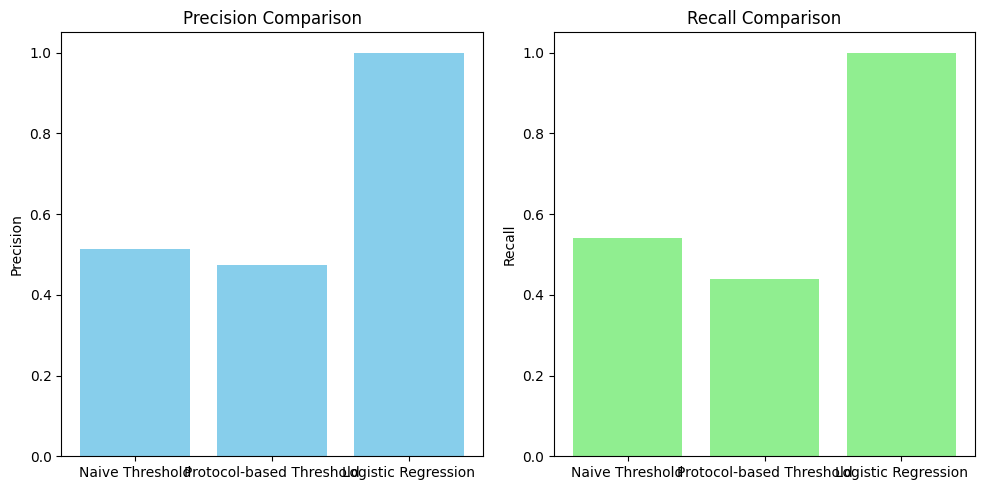

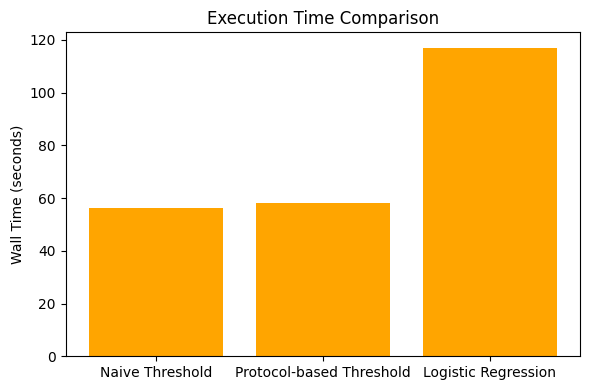

In [10]:
# Method names
methods = ['Naive Threshold', 'Protocol-based Threshold', 'Logistic Regression']

# Precision values
precision = [0.5126, 0.4733, 1.0]

# Recall values
recall = [0.5410, 0.4392, 0.99998]

# Wall time values in seconds
wall_time = [56.2, 58.3, 117]  # Assuming 1min 57s is converted to 117 seconds

# Plotting precision
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(methods, precision, color='skyblue')
plt.title('Precision Comparison')
plt.ylabel('Precision')

# Plotting recall
plt.subplot(1, 2, 2)
plt.bar(methods, recall, color='lightgreen')
plt.title('Recall Comparison')
plt.ylabel('Recall')

plt.tight_layout()

# Plotting wall time
plt.figure(figsize=(6, 4))
plt.bar(methods, wall_time, color='orange')
plt.title('Execution Time Comparison')
plt.ylabel('Wall Time (seconds)')

plt.tight_layout()

plt.show()


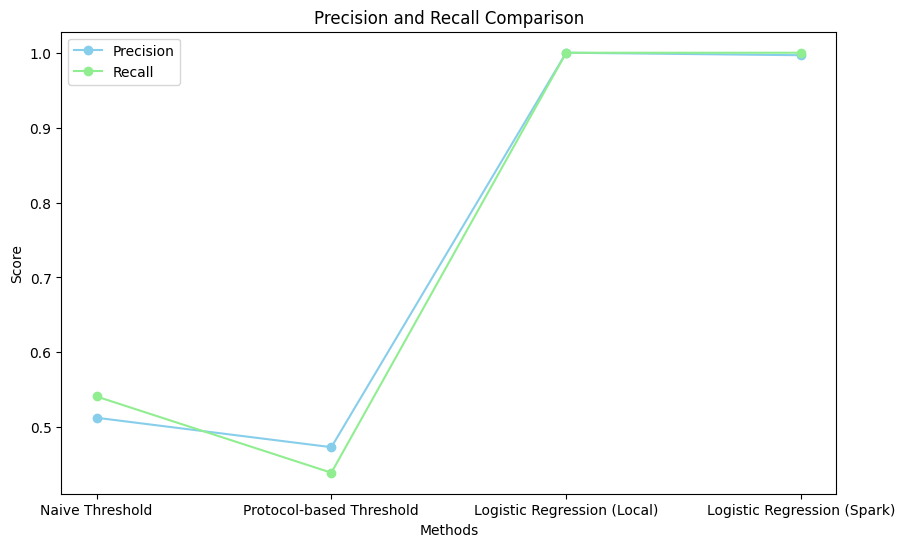

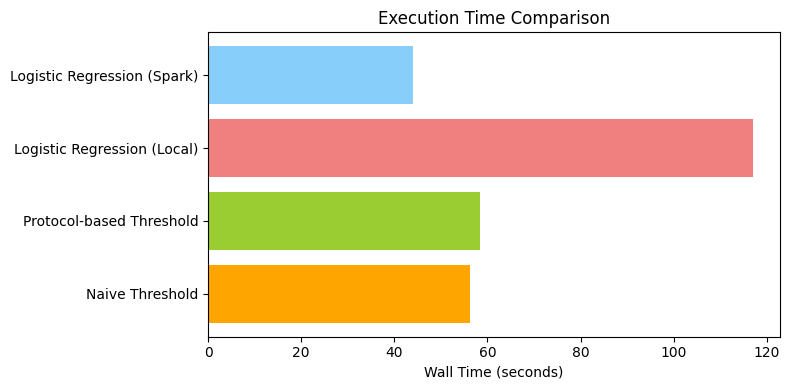

In [14]:
# Method names
methods = ['Protocol-based Threshold', 'Random Forest', 'Logistic Regression', 'DL-LSTM']

# Precision values
precision = [0.5126, 0.98245614, 0.66274, 0.97832]

accuracy = [0.4926, 0.9838712, 0.93405, 0.97605]

# Recall values
recall = [0.5410, 0.9852493, 0.998, 97.377]


# Plotting precision and recall
plt.figure(figsize=(10, 6))
plt.plot(methods, precision, marker='o', label='Precision', color='skyblue')
plt.plot(methods, recall, marker='o', label='Recall', color='lightgreen')
plt.title('Precision and Recall Comparison')
plt.xlabel('Methods')
plt.ylabel('Score')
plt.legend()

# Plotting wall time with different colors
colors = ['orange', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.figure(figsize=(8, 4))
for i, (method, time) in enumerate(zip(methods, wall_time)):
    plt.barh(method, time, color=colors[i])
plt.title('Execution Time Comparison')
plt.xlabel('Wall Time (seconds)')

plt.tight_layout()

plt.show()

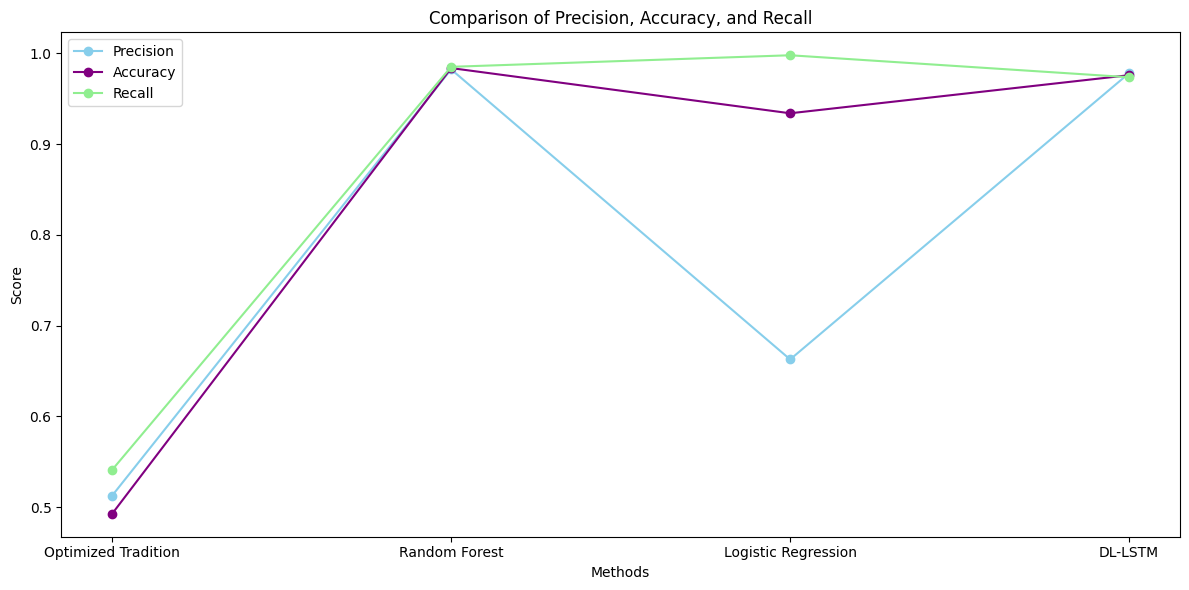

In [1]:
import matplotlib.pyplot as plt

# Method names
methods = ['Optimized Tradition', 'Random Forest', 'Logistic Regression', 'DL-LSTM']

# Precision values
precision = [0.5126, 0.98245614, 0.66274, 0.97832]

# Accuracy values
accuracy = [0.4926, 0.9838712, 0.93405, 0.97605]

# Recall values
recall = [0.5410, 0.9852493, 0.998, 0.97377]  # Fixed the value to be below 1 for consistency

# Plotting precision, accuracy, and recall
plt.figure(figsize=(12, 6))
plt.plot(methods, precision, marker='o', label='Precision', color='skyblue')
plt.plot(methods, accuracy, marker='o', label='Accuracy', color='purple')
plt.plot(methods, recall, marker='o', label='Recall', color='lightgreen')
plt.title('Comparison of Precision, Accuracy, and Recall')
plt.xlabel('Methods')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

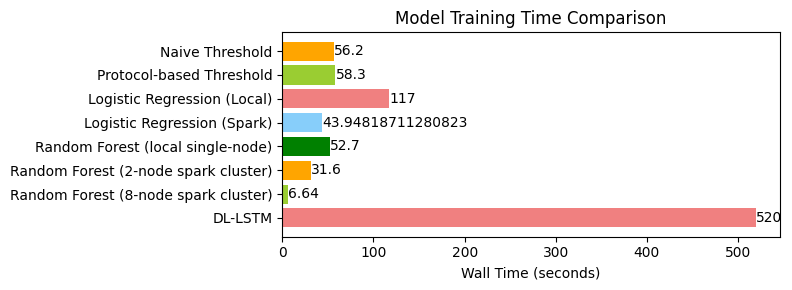

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import matplotlib.pyplot as plt

methods = ['Naive Threshold', 'Protocol-based Threshold', 'Logistic Regression (Local)', 
           'Logistic Regression (Spark)', 'Random Forest (local single-node)', 
           'Random Forest (2-node spark cluster)', 'Random Forest (8-node spark cluster)', 
           'DL-LSTM']

wall_time = [56.2, 58.3, 117, 43.94818711280823, 52.7, 31.6, 6.64, 520]

colors = ['orange', 'yellowgreen', 'lightcoral', 'lightskyblue', 
          'green', 'orange', 'yellowgreen', 'lightcoral']

plt.figure(figsize=(8, 3))  # Increase figure height for better spacing

bar_height = 0.8

for i, (method, time) in enumerate(zip(methods, wall_time)):
    plt.barh(method, time, color=colors[i], height=bar_height)  # Set the height of the bars
    plt.text(time, i, str(time), ha='left', va='center')  # Add value on each bar

plt.title('Model Training Time Comparison')
plt.xlabel('Wall Time (seconds)')
plt.gca().invert_yaxis()  # Invert y-axis to have the methods listed from top to bottom
plt.tight_layout()

plt.show()
